## (a) Importing libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

## (b) Data preparation
- Loading and preparing the dataset

In [2]:
# Load the datasets
white_wine = pd.read_csv('winequality-white.csv', sep=";")
red_wine = pd.read_csv('winequality-red.csv', sep=";")

In [3]:
# Merge the red and white wine datasets
white_wine['type'] = 'white'
red_wine['type'] = 'red'
wine = pd.concat([white_wine, red_wine])

In [4]:
# Prepare the dataset for modeling
X = wine.drop('type', axis=1)
y = wine['type']

In [5]:
# Encode the labels
le = LabelEncoder()
y = le.fit_transform(y)

In [6]:
# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## (c) Model development
- Using TensorFlow and Keras
- Designing 5 different architectures

In [8]:
import tensorflow as tf
from tensorflow.keras import layers

In [9]:
# Define the models
models = []
for _ in range(5):
    model = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])
    models.append(model)

In [10]:
# Train the models
history = []
for model in models:
    hist = model.fit(X_train, y_train,
                     epochs=10,
                     validation_data=(X_val, y_val))
    history.append(hist)

Epoch 1/10
122/122 [==============================] - 1s 5ms/step - loss: 0.1973 - binary_accuracy: 0.9448 - val_loss: 0.0374 - val_binary_accuracy: 0.9915
Epoch 2/10
122/122 [==============================] - 0s 3ms/step - loss: 0.0392 - binary_accuracy: 0.9931 - val_loss: 0.0230 - val_binary_accuracy: 0.9954
Epoch 3/10
122/122 [==============================] - 0s 2ms/step - loss: 0.0315 - binary_accuracy: 0.9941 - val_loss: 0.0175 - val_binary_accuracy: 0.9969
Epoch 4/10
122/122 [==============================] - 0s 3ms/step - loss: 0.0272 - binary_accuracy: 0.9954 - val_loss: 0.0154 - val_binary_accuracy: 0.9969
Epoch 5/10
122/122 [==============================] - 0s 3ms/step - loss: 0.0239 - binary_accuracy: 0.9959 - val_loss: 0.0131 - val_binary_accuracy: 0.9969
Epoch 6/10
122/122 [==============================] - 0s 3ms/step - loss: 0.0222 - binary_accuracy: 0.9962 - val_loss: 0.0140 - val_binary_accuracy: 0.9977
Epoch 7/10
122/122 [==============================] - 0s 2ms/ste

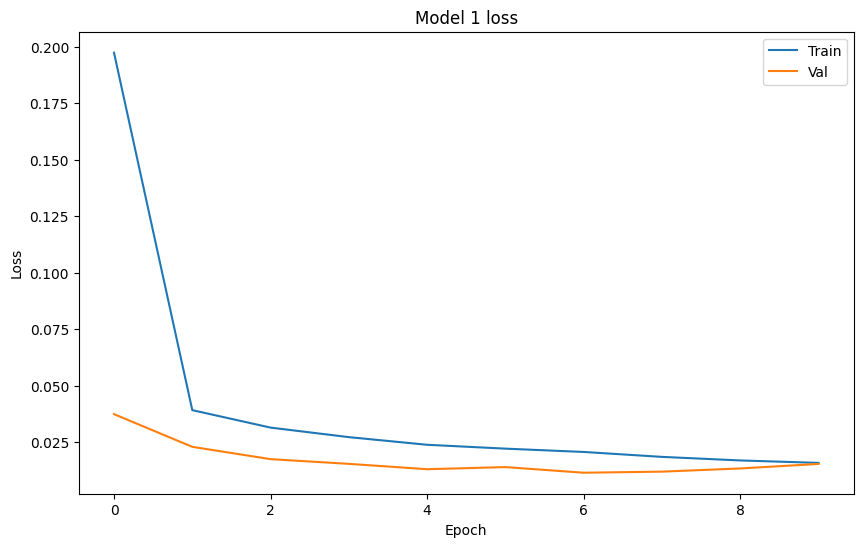

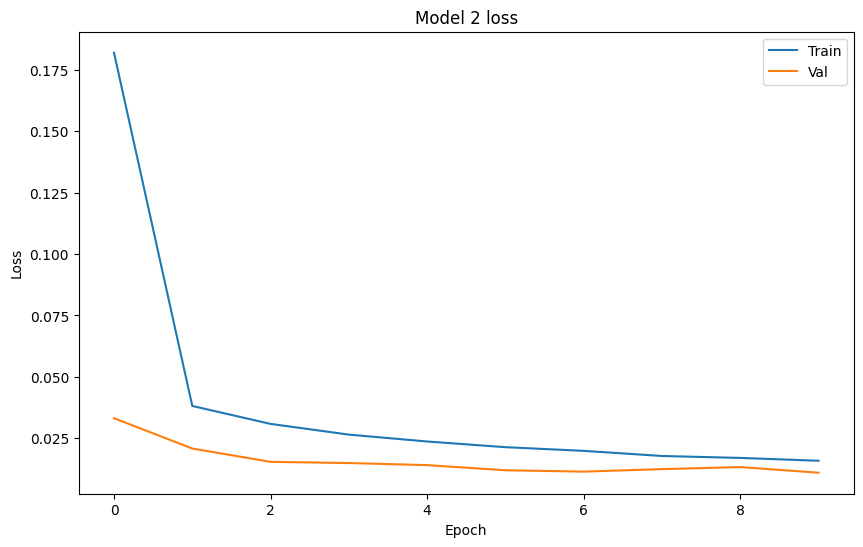

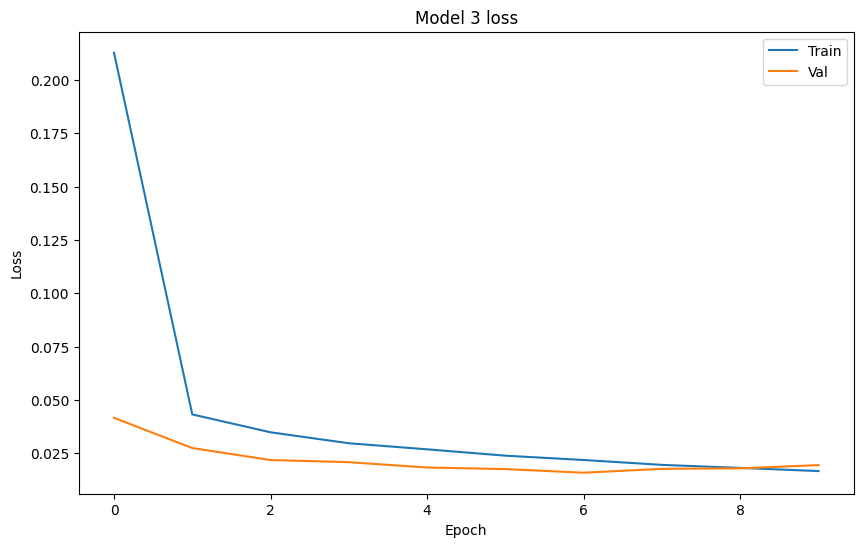

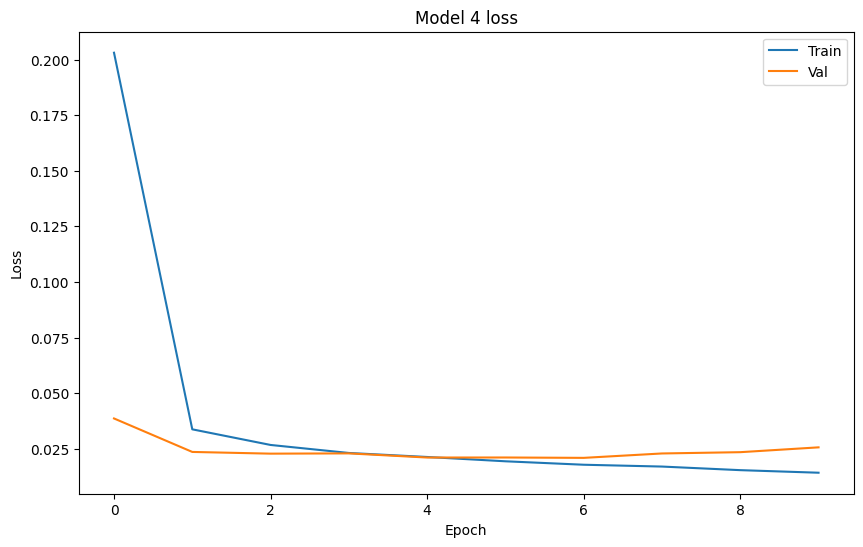

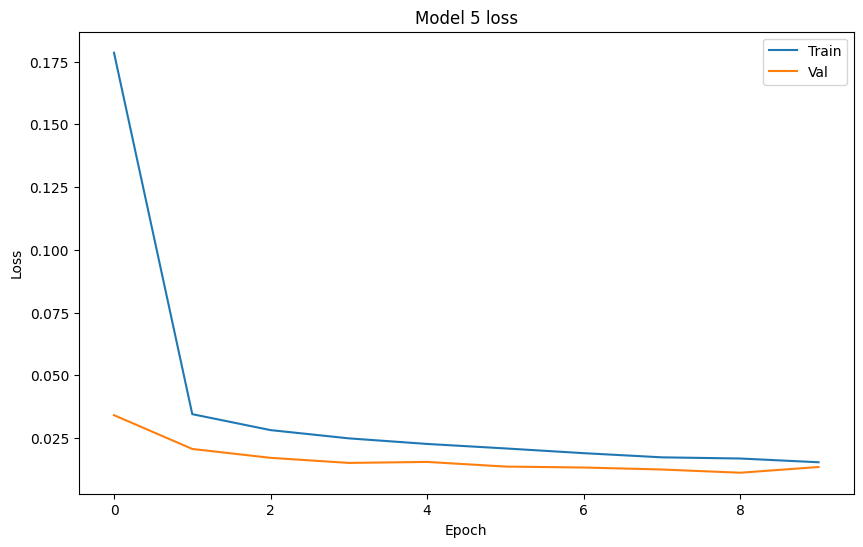

In [11]:
# Required Libraries
import matplotlib.pyplot as plt

# Plot the loss curves for training and validation data 
for i, hist in enumerate(history):
    plt.figure(figsize=(10, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title(f'Model {i+1} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

## (d) Model Tuning
- Hyperparameters tuning

In [12]:
from tensorflow.keras import activations
from kerastuner import HyperModel, RandomSearch

C:\Users\User\AppData\Local\Temp\ipykernel_19100\3260468621.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [13]:
# Define HyperModel class
class WineHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = tf.keras.Sequential()
        model.add(layers.Dense(units=hp.Int('units_input',
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation=activations.relu,
                               input_shape=self.input_shape))
        
        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(layers.Dense(units=hp.Int(f'units_{i}',
                                                min_value=32,
                                                max_value=512,
                                                step=32),
                                   activation=activations.relu))
        
        model.add(layers.Dense(1, activation='sigmoid'))

        model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=[tf.keras.metrics.BinaryAccuracy()])

        return model

In [14]:
# Initialize HyperModel
hypermodel = WineHyperModel(input_shape=(X_train.shape[1],))

In [15]:
# Define the tuner
tuner = RandomSearch(hypermodel,
                     objective='val_binary_accuracy',
                     max_trials=10,
                     executions_per_trial=3,
                     directory='hyperparameter_tuning',
                     project_name='wine_classification')

INFO:tensorflow:Reloading Tuner from hyperparameter_tuning\wine_classification\tuner0.json


In [16]:
# Hyperparameters search
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val))

INFO:tensorflow:Oracle triggered exit


In [17]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Print the hyperparameters of the best model
print(best_model.get_config())

Results summary
Results in hyperparameter_tuning\wine_classification
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 09 summary
Hyperparameters:
units_input: 224
num_layers: 2
units_0: 96
optimizer: adam
units_1: 416
units_2: 192
units_3: 96
units_4: 64
Score: 0.9984603524208069

Trial 04 summary
Hyperparameters:
units_input: 288
num_layers: 1
units_0: 384
optimizer: adam
units_1: 416
units_2: 320
units_3: 288
units_4: 256
Score: 0.9984603524208069

Trial 07 summary
Hyperparameters:
units_input: 160
num_layers: 2
units_0: 480
optimizer: adam
units_1: 512
units_2: 32
units_3: 512
units_4: 288
Score: 0.9982037544250488

Trial 08 summary
Hyperparameters:
units_input: 96
num_layers: 3
units_0: 160
optimizer: adam
units_1: 160
units_2: 512
units_3: 384
units_4: 512
Score: 0.9979471564292908

Trial 01 summary
Hyperparameters:
units_input: 160
num_layers: 5
units_0: 128
optimizer: sgd
units_1: 96
units_2: 64
units_3: 352
units_4: 32
Score: 0.99615089098612

## (e) Model Evaluation
- Compare the validation and testing results using evaluation metrics

In [45]:
# Required Libraries
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [46]:
# Predict on the testing data
y_test_pred = (best_model.predict(X_test) > 0.5).astype('int32')

41/41 [==============================] - 0s 1ms/step


In [47]:
# Print the classification report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       321
           1       0.99      1.00      1.00       979

    accuracy                           0.99      1300
   macro avg       1.00      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



In [48]:
# Print the confusion matrix
print(confusion_matrix(y_test, y_test_pred))

[[314   7]
 [  0 979]]


In [49]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

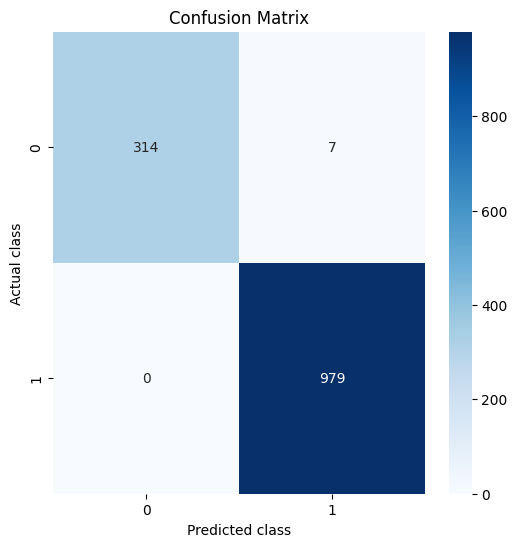

In [50]:
# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

In [51]:
# Calculate the probabilities of the predictions
y_test_prob = best_model.predict(X_test)

41/41 [==============================] - 0s 1ms/step


In [52]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

In [53]:
# Calculate AUC score
auc_score = roc_auc_score(y_test, y_test_prob)

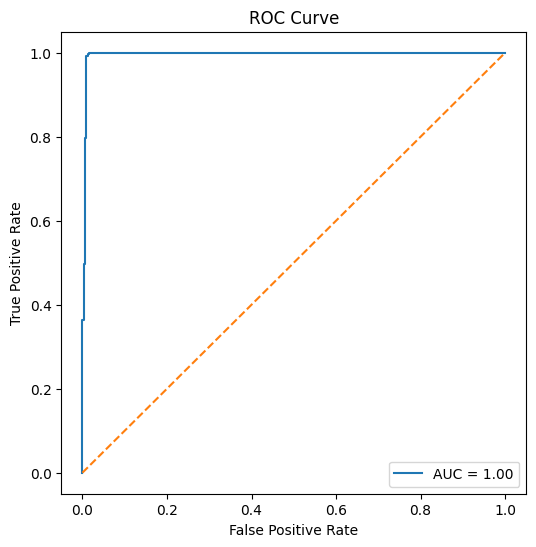

In [54]:
# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()